In [1]:
# CELL 1: Environment setup
!pip install -q "timm>=0.9.16" "torchinfo>=1.8.0" "seaborn>=0.13" "scikit-learn>=1.5" tqdm opencv-python==4.8.1.78

import os, random, numpy as np, torch

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("results", exist_ok=True)
print("Device:", device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 10.7 MB/s eta 0:00:00
Device: cuda


/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


In [2]:
# CELL 2: Kaggle download + unzip + dedupe + canonicalize to /content/leapGestRecog
!pip install -q kaggle
import os, subprocess, glob, shutil
from getpass import getpass

ROOT = "/content"
CANON_PATH = os.path.join(ROOT, "leapGestRecog")
TMP_DIR = os.path.join(ROOT, "_leap_tmp")

def is_dataset_root(p):
    try:
        return os.path.isdir(p) and all(os.path.isdir(os.path.join(p, f"{i:02d}")) for i in range(10))
    except Exception:
        return False

def count_png(p):
    import glob as _g
    return len(_g.glob(f"{p}/**/*.png", recursive=True)) if os.path.isdir(p) else -1

print("== Kaggle one-shot download to /content (dedupe + canonicalize) ==")

deep = os.path.join(ROOT, "leapgestrecog", "leapGestRecog")
upper = os.path.join(ROOT, "LeapGestRecog")
lower = os.path.join(ROOT, "leapGestRecog")
existing_roots = [p for p in [deep, upper, lower] if is_dataset_root(p)]
if is_dataset_root(CANON_PATH):
    DATASET_PATH = CANON_PATH
elif existing_roots:
    best = max(existing_roots, key=count_png)
    if os.path.exists(CANON_PATH):
        shutil.rmtree(CANON_PATH)
    shutil.move(best, CANON_PATH)
    parent = os.path.dirname(best)
    if parent != ROOT and os.path.isdir(parent):
        try: shutil.rmtree(parent)
        except: pass
    DATASET_PATH = CANON_PATH
else:
    if not os.environ.get("KAGGLE_USERNAME") or not os.environ.get("KAGGLE_KEY"):
        os.environ["KAGGLE_USERNAME"] = input("Kaggle username: ").strip()
        os.environ["KAGGLE_KEY"] = getpass("Kaggle API key (hidden): ").strip()

    shutil.rmtree(TMP_DIR, ignore_errors=True)
    os.makedirs(TMP_DIR, exist_ok=True)
    for z in glob.glob(os.path.join(ROOT, "*.zip")):
        try: os.remove(z)
        except: pass

    slug = "gti-upm/leapgestrecog"
    res = subprocess.run(
        ["kaggle", "datasets", "download", "-d", slug, "-p", ROOT, "-q"],
        capture_output=True, text=True
    )
    if res.returncode != 0:
        print("Kaggle download failed.")
        if "403" in res.stderr or "403" in res.stdout or "Unauthorized" in res.stderr:
            print("- Open and Accept the dataset terms, then rerun:")
            print("  https://www.kaggle.com/datasets/gti-upm/leapgestrecog")
        else:
            print("STDOUT:", res.stdout[:400]); print("STDERR:", res.stderr[:400])
        raise SystemExit(1)

    zips = sorted(glob.glob(os.path.join(ROOT, "*.zip")), key=os.path.getmtime, reverse=True)
    if not zips: raise SystemExit("No zip downloaded to /content.")
    outer_zip = zips[0]

    subprocess.run(["unzip", "-q", outer_zip, "-d", TMP_DIR], check=True)

    inner_zips = glob.glob(os.path.join(TMP_DIR, "**", "*.zip"), recursive=True)
    if inner_zips:
        inner_zip = max(inner_zips, key=os.path.getsize)
        subprocess.run(["unzip", "-q", inner_zip, "-d", ROOT], check=True)
    else:
        candidate_dirs = []
        for root, dirs, files in os.walk(TMP_DIR):
            candidate_dirs.append(root)
        dataset_dirs = [p for p in candidate_dirs if is_dataset_root(p)]
        if not dataset_dirs:
            for name in ["leapGestRecog", "LeapGestRecog"]:
                p = os.path.join(TMP_DIR, name)
                if is_dataset_root(p):
                    dataset_dirs = [p]; break
        if not dataset_dirs:
            raise SystemExit("Could not locate dataset folder after unzip.")
        src = max(dataset_dirs, key=count_png)
        if os.path.exists(CANON_PATH):
            shutil.rmtree(CANON_PATH)
        shutil.move(src, CANON_PATH)

    try: os.remove(outer_zip)
    except: pass
    shutil.rmtree(TMP_DIR, ignore_errors=True)
    DATASET_PATH = CANON_PATH

for p in [os.path.join(ROOT, "LeapGestRecog"), os.path.join(ROOT, "leapGestRecog")]:
    if is_dataset_root(p) and p != CANON_PATH:
        if os.path.exists(CANON_PATH): shutil.rmtree(CANON_PATH)
        shutil.move(p, CANON_PATH)

assert is_dataset_root(CANON_PATH), "Final dataset folder not found or malformed."

import glob as _g
imgs = _g.glob(f"{CANON_PATH}/**/*.png", recursive=True)
print(f"Dataset ready at: {CANON_PATH} | images: {len(imgs)}")
print("Subjects:", sorted([d for d in os.listdir(CANON_PATH) if os.path.isdir(os.path.join(CANON_PATH, d))]))
DATASET_PATH = CANON_PATH

== Kaggle one-shot download to /content (dedupe + canonicalize) ==
Kaggle username: abdosabry2003
Kaggle API key (hidden): ··········
Dataset ready at: /content/leapGestRecog | images: 20000
Subjects: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']


In [3]:
# CELL 3: Subject-independent split (7 train, 2 val, 1 test) + sanity
import os
from collections import Counter

train_subjects = ['00','01','02','03','04','05','06']
val_subjects   = ['07','08']
test_subjects  = ['09']

gesture_map = {
    '01_palm': 0, '02_l': 1, '03_fist': 2, '04_fist_moved': 3, '05_thumb': 4,
    '06_index': 5, '07_ok': 6, '08_palm_moved': 7, '09_c': 8, '10_down': 9
}
gesture_names = ['palm','l','fist','fist_moved','thumb','index','ok','palm_moved','c','down']
num_classes = len(gesture_names)

def get_paths_and_labels(base_path, selected_subjects):
    paths, labels = [], []
    for subject in selected_subjects:
        subject_path = os.path.join(base_path, subject)
        for gesture_folder, idx in gesture_map.items():
            folder = os.path.join(subject_path, gesture_folder)
            if not os.path.isdir(folder): continue
            for name in os.listdir(folder):
                if name.lower().endswith(".png"):
                    paths.append(os.path.join(folder, name))
                    labels.append(idx)
    return paths, labels

train_paths, train_labels = get_paths_and_labels(DATASET_PATH, train_subjects)
val_paths,   val_labels   = get_paths_and_labels(DATASET_PATH, val_subjects)
test_paths,  test_labels  = get_paths_and_labels(DATASET_PATH, test_subjects)

def sanity(name, labels):
    cnt = dict(sorted(Counter(labels).items()))
    print(f"{name} images: {len(labels)} | per-class:", cnt)

print(f"Root: {DATASET_PATH}")
sanity("Train", train_labels)
sanity("Val  ", val_labels)
sanity("Test ", test_labels)

Root: /content/leapGestRecog
Train images: 14000 | per-class: {0: 1400, 1: 1400, 2: 1400, 3: 1400, 4: 1400, 5: 1400, 6: 1400, 7: 1400, 8: 1400, 9: 1400}
Val   images: 4000 | per-class: {0: 400, 1: 400, 2: 400, 3: 400, 4: 400, 5: 400, 6: 400, 7: 400, 8: 400, 9: 400}
Test  images: 2000 | per-class: {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200, 9: 200}


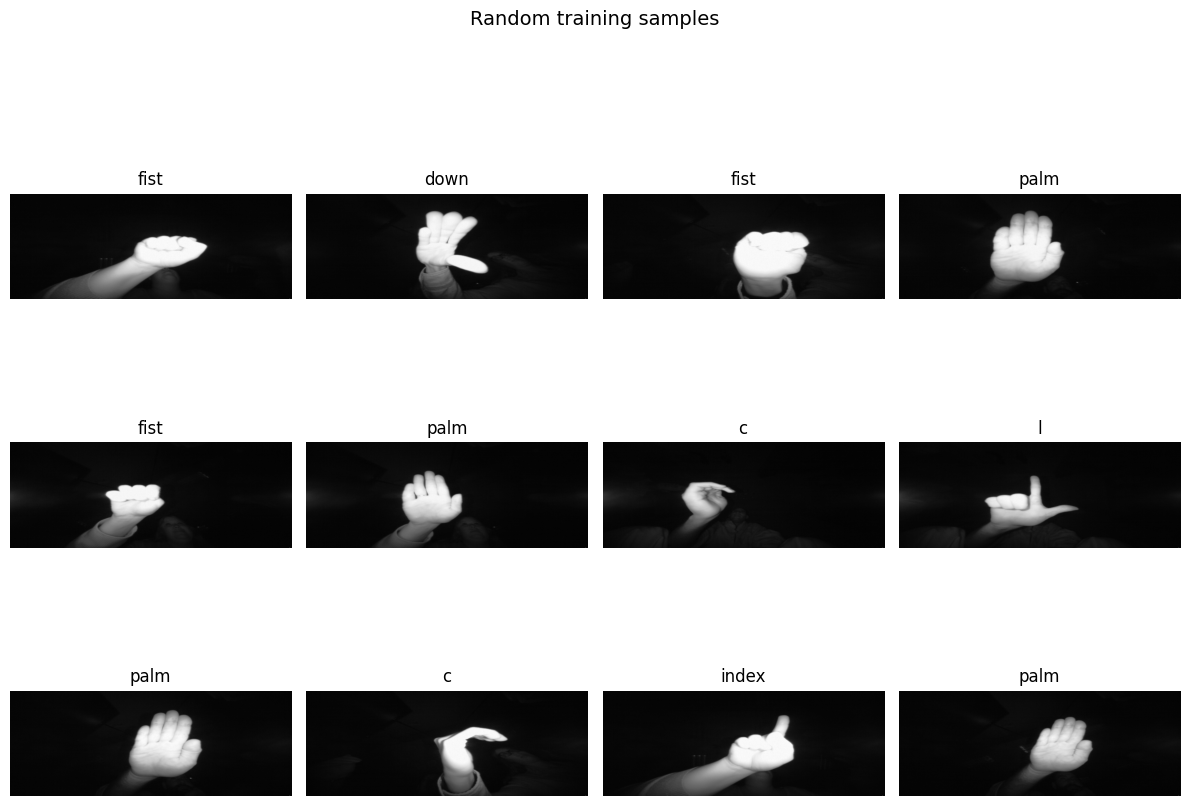

In [4]:
# CELL 3b (optional): Quick EDA preview
import random, matplotlib.pyplot as plt
from PIL import Image

samples = random.sample(list(zip(train_paths, train_labels)), k=12)
plt.figure(figsize=(12,9))
for i, (p, y) in enumerate(samples, 1):
    plt.subplot(3,4,i); plt.imshow(Image.open(p).convert("RGB")); plt.axis("off"); plt.title(gesture_names[y])
plt.suptitle("Random training samples", y=1.02, fontsize=14); plt.tight_layout(); plt.show()

In [5]:
# CELL 4: Transforms, Dataset, DataLoaders (simplified) + optional grayscale
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

USE_GRAYSCALE = True  # جرّب True أولاً

base_norm_mean = [0.485, 0.456, 0.406]
base_norm_std  = [0.229, 0.224, 0.225]
prepend_gray = [transforms.Grayscale(num_output_channels=3)] if USE_GRAYSCALE else []

train_transform = transforms.Compose(
    prepend_gray + [
        transforms.Resize(256),
        transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.98, 1.02)),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(base_norm_mean, base_norm_std),
    ]
)
val_test_transform = transforms.Compose(
    prepend_gray + [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(base_norm_mean, base_norm_std),
    ]
)

class GestureDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths; self.labels = labels; self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB"); y = self.labels[idx]
        if self.transform: img = self.transform(img)
        return img, y

train_dataset = GestureDataset(train_paths, train_labels, train_transform)
val_dataset   = GestureDataset(val_paths,   val_labels,   val_test_transform)
test_dataset  = GestureDataset(test_paths,  test_labels,  val_test_transform)

BATCH_SIZE = 32  # زوّد لـ 64 لو الميموري تسمح
NUM_WORKERS = 2
loader_kwargs = dict(num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=2)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  **loader_kwargs)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, **loader_kwargs)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, **loader_kwargs)

print("DataLoaders ready (simplified aug).")

DataLoaders ready (simplified aug).


In [6]:
# CELL 5: ViT model (timm) + summary
import timm
from torchinfo import summary
import torch.nn as nn, torch

model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes).to(device)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model: ViT-B/16 | Total params: {total_params:,} | Trainable: {trainable_params:,}")
summary(model, input_size=(1, 3, 224, 224))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Model: ViT-B/16 | Total params: 85,806,346 | Trainable: 85,806,346


Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformer                        [1, 10]                   152,064
├─PatchEmbed: 1-1                        [1, 196, 768]             --
│    └─Conv2d: 2-1                       [1, 768, 14, 14]          590,592
│    └─Identity: 2-2                     [1, 196, 768]             --
├─Dropout: 1-2                           [1, 197, 768]             --
├─Identity: 1-3                          [1, 197, 768]             --
├─Identity: 1-4                          [1, 197, 768]             --
├─Sequential: 1-5                        [1, 197, 768]             --
│    └─Block: 2-3                        [1, 197, 768]             --
│    │    └─LayerNorm: 3-1               [1, 197, 768]             1,536
│    │    └─Attention: 3-2               [1, 197, 768]             2,362,368
│    │    └─Identity: 3-3                [1, 197, 768]             --
│    │    └─Identity: 3-4                [1, 197, 768]           

In [7]:
# CELL 6: Two-stage fine-tuning setup + AMP
import torch.nn as nn, torch.optim as optim, torch

criterion = nn.CrossEntropyLoss(label_smoothing=0.02)

# Stage 1: freeze backbone, train head only
for p in model.parameters(): p.requires_grad = False
for p in model.head.parameters(): p.requires_grad = True

optimizer = optim.AdamW(model.head.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

EPOCHS_STAGE1 = 5
EPOCHS_STAGE2 = 20  # early stop on val_acc هيوقف بدري غالبًا
best_val_acc = 0.0

# Early stop on val_acc (no improvement ≥ 0.2% for 3 epochs)
patience_acc = 3
min_delta_acc = 0.2  # 0.2%

/tmp/ipython-input-4013518891.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [8]:
# CELL 7: Train (Stage 1 head-only) → (Stage 2 full FT) with AMP and early stop on val_acc
from tqdm.auto import tqdm
import torch, pandas as pd

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

def run_one_epoch(train=True):
    loader = train_loader if train else val_loader
    if train: model.train()
    else: model.eval()
    total_loss, total_correct, total_num = 0.0, 0, 0
    for inputs, labels in loader:
        inputs = inputs.to(device, non_blocking=True); labels = labels.to(device, non_blocking=True)
        if train: optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        if train:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer); scaler.update()
        total_loss += loss.item()
        total_num += labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss/len(loader), 100.0*total_correct/total_num

print("Stage 1: Linear probe (head only)")
for epoch in range(EPOCHS_STAGE1):
    tr_loss, tr_acc = run_one_epoch(train=True)
    val_loss, val_acc = run_one_epoch(train=False)
    scheduler.step(epoch + 1)
    history['train_loss'].append(tr_loss); history['val_loss'].append(val_loss)
    history['train_acc'].append(tr_acc);   history['val_acc'].append(val_acc)
    print(f"[S1 E{epoch+1:02d}] Train {tr_acc:.2f}% | Val {val_acc:.2f}% | ValLoss {val_loss:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_vit_gesture.pth")
        print("  → New best model saved (S1)")

# Stage 2: unfreeze + param groups
for p in model.parameters(): p.requires_grad = True
backbone = [p for n,p in model.named_parameters() if "head" not in n]
optimizer = optim.AdamW(
    [{"params": backbone, "lr": 2e-5},
     {"params": model.head.parameters(), "lr": 1e-4}],
    weight_decay=0.05
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

print("\nStage 2: Full fine-tuning")
no_improve = 0
best_val_acc_local = best_val_acc

for epoch in range(EPOCHS_STAGE2):
    tr_loss, tr_acc = run_one_epoch(train=True)
    val_loss, val_acc = run_one_epoch(train=False)
    scheduler.step(epoch + 1)

    history['train_loss'].append(tr_loss); history['val_loss'].append(val_loss)
    history['train_acc'].append(tr_acc);   history['val_acc'].append(val_acc)

    print(f"[S2 E{epoch+1:02d}] Train {tr_acc:.2f}% | Val {val_acc:.2f}% | ValLoss {val_loss:.4f}")

    if val_acc > best_val_acc + 1e-9:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_vit_gesture.pth")
        print("  → New best model saved (S2)")

    if val_acc > best_val_acc_local + min_delta_acc:
        best_val_acc_local = val_acc
        no_improve = 0
    else:
        no_improve += 1
    if no_improve >= patience_acc:
        print("  → Early stopping on val_acc")
        break

print(f"\nBest Val Acc: {best_val_acc:.2f}%")
pd.DataFrame(history).to_csv("results/vit_history.csv", index=False)

Stage 1: Linear probe (head only)
[S1 E01] Train 96.41% | Val 74.25% | ValLoss 0.8890
  → New best model saved (S1)
[S1 E02] Train 99.95% | Val 79.50% | ValLoss 0.8150
  → New best model saved (S1)
[S1 E03] Train 99.99% | Val 78.55% | ValLoss 0.8076
[S1 E04] Train 100.00% | Val 78.28% | ValLoss 0.8312
[S1 E05] Train 99.99% | Val 79.80% | ValLoss 0.7896
  → New best model saved (S1)

Stage 2: Full fine-tuning
[S2 E01] Train 99.53% | Val 94.25% | ValLoss 0.3472
  → New best model saved (S2)
[S2 E02] Train 100.00% | Val 94.28% | ValLoss 0.3369
  → New best model saved (S2)
[S2 E03] Train 100.00% | Val 93.95% | ValLoss 0.3271
[S2 E04] Train 100.00% | Val 93.95% | ValLoss 0.3279
  → Early stopping on val_acc

Best Val Acc: 94.28%


FINAL TEST ACCURACY (held-out subject): 100.000%


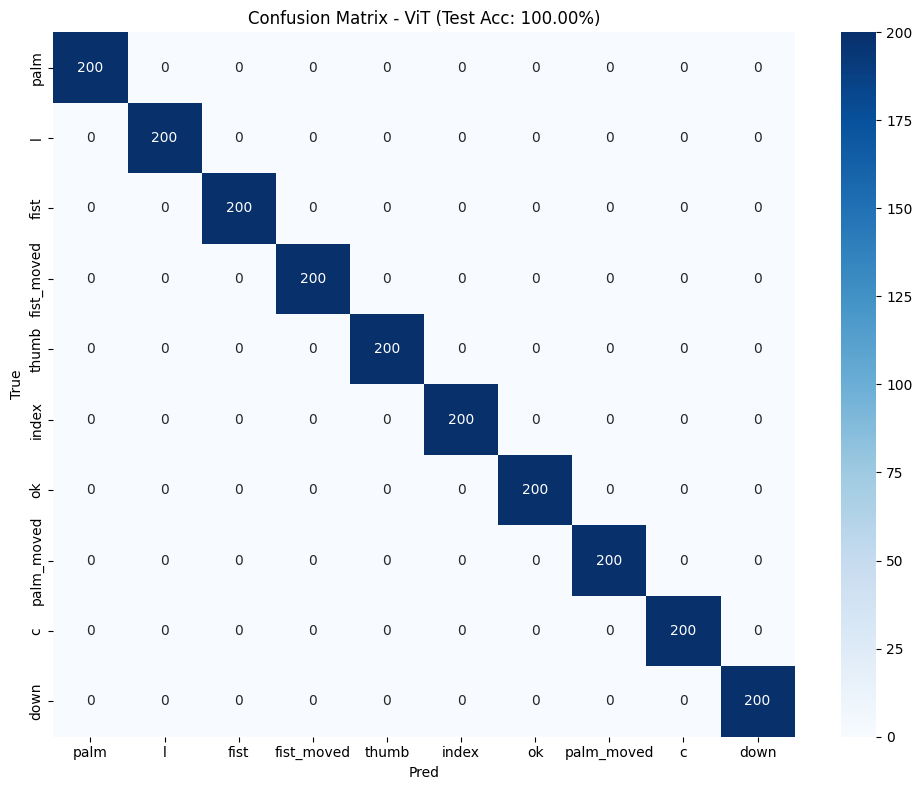

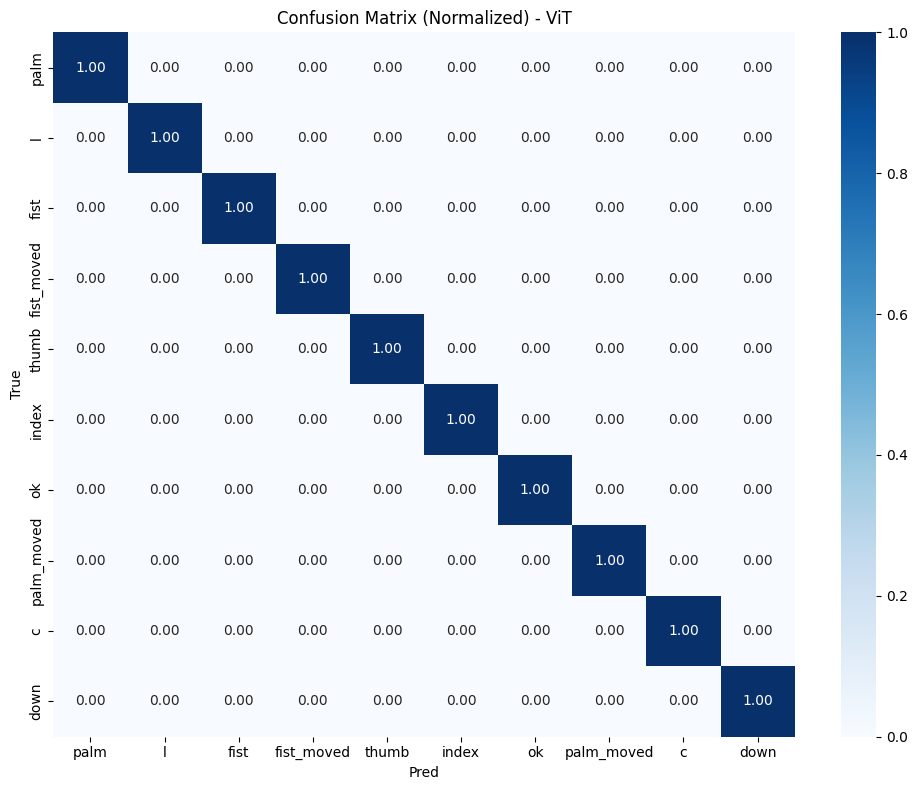

Saved reports in results/


In [9]:
# CELL 8: Final test evaluation + confusion matrices + reports (AMP new API)
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch, os

model.load_state_dict(torch.load("best_vit_gesture.pth", map_location=device))
model.eval()

all_preds, all_labels, all_probs = [], [], []
with torch.no_grad(), torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
    for inputs, labels in test_loader:
        probs = torch.softmax(model(inputs.to(device, non_blocking=True)), dim=1).cpu().numpy()
        preds = probs.argmax(1)
        all_probs.extend(probs); all_preds.extend(preds); all_labels.extend(labels.numpy())

all_probs = np.array(all_probs)
test_acc = 100.0 * np.mean(np.array(all_preds) == np.array(all_labels))
print(f"FINAL TEST ACCURACY (held-out subject): {test_acc:.3f}%")

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=gesture_names, yticklabels=gesture_names)
plt.title(f'Confusion Matrix - ViT (Test Acc: {test_acc:.2f}%)'); plt.ylabel('True'); plt.xlabel('Pred')
plt.tight_layout(); plt.savefig("results/vit_confusion_matrix_raw.png", dpi=150); plt.show()

cm_norm = cm / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=gesture_names, yticklabels=gesture_names)
plt.title('Confusion Matrix (Normalized) - ViT'); plt.ylabel('True'); plt.xlabel('Pred')
plt.tight_layout(); plt.savefig("results/vit_confusion_matrix_norm.png", dpi=150); plt.show()

rep = classification_report(all_labels, all_preds, target_names=gesture_names, output_dict=True)
pd.DataFrame(rep).transpose().to_csv("results/vit_classification_report.csv")
pd.DataFrame({"true": all_labels, "pred": all_preds}).to_csv("results/vit_test_predictions.csv", index=False)
print("Saved reports in results/")

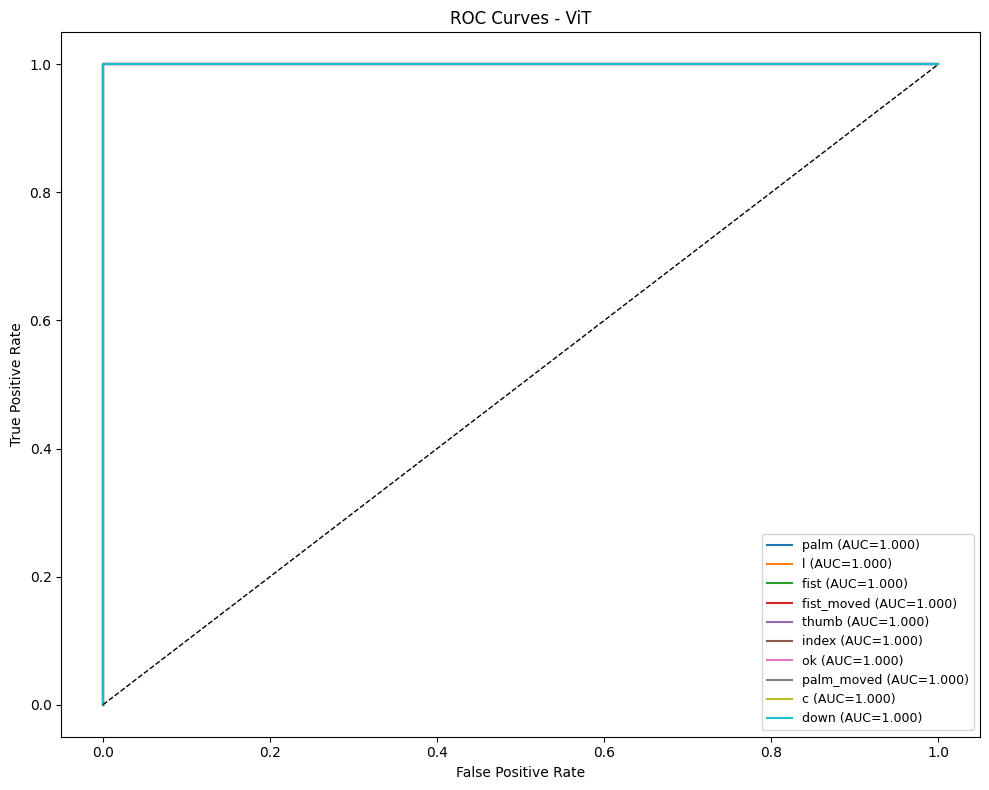

Macro AUC: 1.0000 | Micro AUC: 1.0000


In [10]:
# CELL 9: ROC/AUC (per-class, micro, macro)
import numpy as np, matplotlib.pyplot as plt, json
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score

y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))
auc_scores = []
plt.figure(figsize=(10,8))

for i in range(num_classes):
    if y_true_bin[:, i].sum() in (0, len(y_true_bin)):
        continue
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    auc = roc_auc_score(y_true_bin[:, i], all_probs[:, i])
    auc_scores.append(auc)
    plt.plot(fpr, tpr, label=f'{gesture_names[i]} (AUC={auc:.3f})')

plt.plot([0,1],[0,1],'k--', lw=1)
plt.title('ROC Curves - ViT'); plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize=9)
plt.tight_layout(); plt.savefig("results/vit_roc_curves.png", dpi=150); plt.show()

macro_auc = roc_auc_score(y_true_bin, all_probs, average="macro", multi_class="ovr")
micro_auc = roc_auc_score(y_true_bin, all_probs, average="micro", multi_class="ovr")
print(f"Macro AUC: {macro_auc:.4f} | Micro AUC: {micro_auc:.4f}")
with open("results/vit_auc.json","w") as f:
    json.dump({"macro_auc": float(macro_auc), "micro_auc": float(micro_auc)}, f, indent=2)

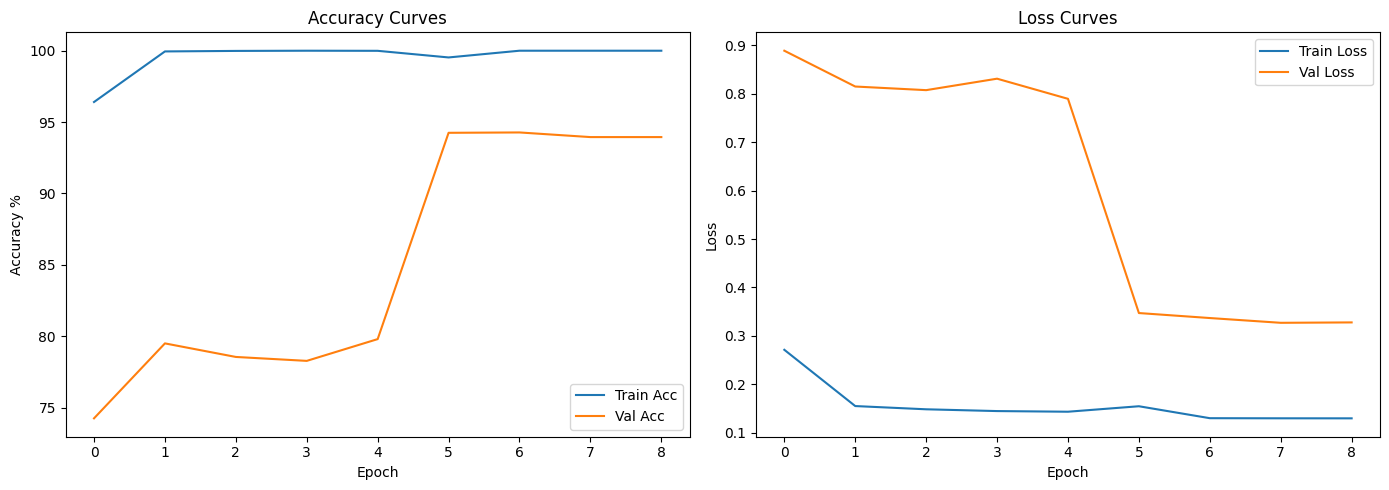

In [11]:
# CELL 10: Training curves
import matplotlib.pyplot as plt, pandas as pd

hist_df = pd.read_csv("results/vit_history.csv")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(hist_df['train_acc'], label='Train Acc'); plt.plot(hist_df['val_acc'], label='Val Acc')
plt.title('Accuracy Curves'); plt.xlabel('Epoch'); plt.ylabel('Accuracy %'); plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_df['train_loss'], label='Train Loss'); plt.plot(hist_df['val_loss'], label='Val Loss')
plt.title('Loss Curves'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.tight_layout(); plt.savefig("results/vit_training_curves.png", dpi=150); plt.show()

In [12]:
# CELL 11: Upload & Predict demo (Colab-friendly)
from google.colab import files
from PIL import Image
import io, numpy as np, torch

def predict_image(img: Image.Image):
    model.eval()
    x = val_test_transform(img).unsqueeze(0).to(device)
    with torch.no_grad(), torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
        probs = torch.softmax(model(x), dim=1).cpu().numpy()[0]
    pred = int(np.argmax(probs))
    return gesture_names[pred], probs[pred]

print("Upload one or more PNG/JPG gesture images...")
uploaded = files.upload()
for name, data in uploaded.items():
    img = Image.open(io.BytesIO(data)).convert("RGB")
    pred, conf = predict_image(img)
    print(f"{name} → {pred} ({conf*100:.2f}%)")
    display(img.resize((256,256)))

Upload one or more PNG/JPG gesture images...


In [13]:
# OPTIONAL: split sanity + inference speed
import re, time
def get_subject_ids(paths):
    return set([re.search(r'/(\d{2})/', p).group(1) for p in paths])

train_subj = get_subject_ids(train_paths); val_subj = get_subject_ids(val_paths); test_subj = get_subject_ids(test_paths)
print("Train:", train_subj, "Val:", val_subj, "Test:", test_subj)
assert train_subj.isdisjoint(val_subj) and train_subj.isdisjoint(test_subj) and val_subj.isdisjoint(test_subj)
print("Subject-independent split: OK ✅")

# Inference throughput
model.eval(); start = time.time()
with torch.no_grad(), torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
    for x,_ in test_loader: _ = model(x.to(device, non_blocking=True))
elapsed = time.time() - start
print(f"Throughput: {len(test_dataset)/elapsed:.1f} img/s | {elapsed/len(test_dataset)*1000:.2f} ms/img")

Train: {'01', '04', '00', '06', '05', '02', '03'} Val: {'07', '08'} Test: {'09'}
Subject-independent split: OK ✅
Throughput: 107.2 img/s | 9.33 ms/img
